In [1]:
import numpy as np
import matplotlib.pyplot as plt
import detection_utils as utils
from detection_utils import e, m, kB 
from detection_utils import plot, plot_ax, plot_errbar, plot_power_spectrum
from detection_utils import W_to_dBm, dBm_to_W, dB_to_frac, frac_to_dB, voltage_noise_to_dBm
from detection_utils import find_width, moving_avg
from detection_utils import Component, DetectionSetup
from detection_utils import BandPassFilter, SpectrumAnalyzer, Amplifier
from detection_utils import HarmonicElectron, TankCircuit
from detection_utils import HarmoincElectronCoupledTank, ElectronCoupledToTank
from detection_utils import AnharmonicElectronSetup

In [2]:
?TankCircuit

Init signature: TankCircuit(Q, Z0, omega_0, T=4, name='TankCircuit')
Docstring:     
Base class for a circuit component used. Has some 
common functions needed for all circuit elements.
Init docstring:
Tank circuit.

Parameters
----------
Q : int
    Quality factor of tank circuit
Z0 : [Ohm]
    Characteristic impedance of the tank circuit
omega_0 : [rad/s]
    Resonant frequency of the tank circuit, 
    in angular frequency
File:           c:\users\electron\edes\edes\modules\detection\detection_utils.py
Type:           type
Subclasses:     

In [6]:
circ = TankCircuit(500, 300, 2*np.pi*300e6, T=300)
circ.L, circ.C

(1.5915494309189535e-07, 1.7683882565766149e-12)

In [2]:
plt.rcParams['font.size'] = 13.5
np.random.seed(12345)

In [2]:
?AnharmonicElectronSetup

Init signature:
AnharmonicElectronSetup(
    n,
    d,
    Q,
    Z0,
    f0,
    fz_0,
    delta_fz,
    T,
    BW_measurement,
    Z_measurement,
    noise_floor,
    N_average,
    m=9.1093837015e-31,
    e=1.602176634e-19,
    devices=[],
    display_progress=False,
    name='AnharmonicElectron',
)
Docstring:     
Base class for a circuit component used. Has some 
common functions needed for all circuit elements.
Init docstring:
The electron coupled to a tank circuit, with a sequence of devices
applied in series to the signal after tank circuit. A finite width
is assumed and the electron's motional spectrum has a Gaussian 
distribution with width delta_fz (std = delta_fz/2).

Parameters
----------
n : int
    Number of electrons 
d : [m]
    Effective distance
m : [kg]
    Mass of electron
e : [c]
    Magnitude of the charge of electron
Q : int
    Quality factor of tank circuit
Z0 : [Ohm]
    Characteristic impedance of the tank circuit
f0 : [Hz]
    Resonant frequency of the tank

In [3]:
def find_SNR(x, y, debug):
    i_min = len(y)//2
    i_max1 = np.argmax(y[len(y)//5:i_min])+len(y)//5
    i_max2 = np.argmax(y[i_min:-len(y)//5])+i_min
    y_min = np.min([i for i in y[i_max1+1:i_max2] if not np.isnan(i)])  # adjust for nan
    i_y_min = [i for i in np.where(y==y_min) if i > i_max1 and i < i_max2][0]
    y_max = np.max(y[~np.isnan(y)])
    if debug:
        plot(x, y)
        plot(x[np.where(y==y_max)], y_max, 'X', markersize=10)
        plot(x[i_y_min], y_min, 'o', markersize=10)
    return y_max - y_min
    
def find_SNR_with_err(x, y, n=10, debug=False):
    """
    Find the SNR in dB and the associated errorbar.
    The error bars are found by finding the SNR again
    on a more denoised signal, by applying a moving average
    with size n*signal_resolution. NOTE: not used rn...
    """
    noisy_SNR = find_SNR(x, y, debug)
    smooth_SNR = find_SNR(x, moving_avg(y, window=n, display_progress=False), debug)
    return smooth_SNR, abs(noisy_SNR-smooth_SNR)

def plot_SNR_variations(all_width_factor, all_deff, all_SNR, Q, Z0, T, n, f0=70):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xscale('log')
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    for i in range(len(all_width_factor)):
        plot_ax(ax, all_deff*1e6, all_SNR[i], 'o--', label=f'$\Delta f/f_0 = {all_width_factor[i]:.0e}$')
        plot_ax(ax2, all_deff*1e6, all_SNR[i], '.')
    ax.set_ylabel('SNR (dB)')
    ax.set_xlabel('$d_{eff}$ (um)')
    ax2.set_xlabel('$\gamma/2\pi$ (KHz)')
    ax2.set_xticklabels([f'{i:.3f}' for i in e**2*Q*Z0/m/(ax2.get_xticks()*1e-6)**2/2e3/np.pi])
    ax.set_title(f'$T = ${T}K, $f_0 = ${f0}MHz, $n = {n}$')
    ax.legend(bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()

## Effect of amplifier

### Signal directly after tank circuit
Electron -> Tank circuit -> Spectrum Analyzer

In [167]:
n = 1  # number of electrons
d = 254e-6  # effective distance, in m
Q = 500  # quality factor of tank circuit
Z0 = 300  # characteristic impedance of the tank circuit, in Ohm
f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
delta_fz = fz_0 * 1e-4  # Width of the motional frequency of the electron
T = 4  # temperature of the tank circuit, in K

BW_meas = 100  # Hz, measurement bandwidth
Z_meas = 50  # Ohm, measurement impedance
noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer

plot_rg = 0.2e6  # Hz, plotting range
display_progress = False
N_average = 32  # The number of shots to take and do averaging on
devices = []  # Empty since no device is used after the tank circuit

freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                            delta_fz, T,
                                            BW_meas, Z_meas, noise_floor,
                                            N_average, m, e, devices, 
                                            display_progress)

100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


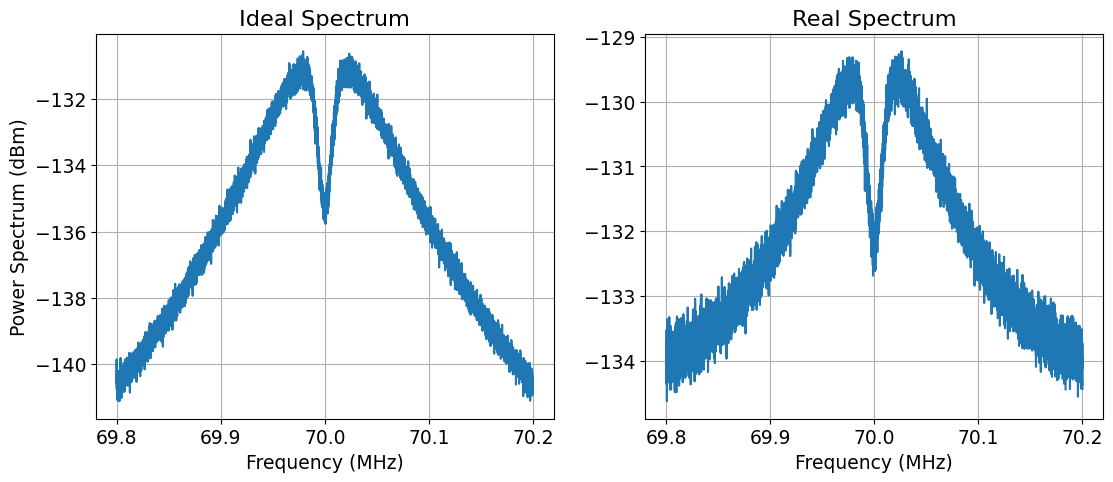

In [168]:
ideal_spectrum, real_spectrum = gaussian_electron(freq)
plot_power_spectrum(freq, ideal_spectrum, real_spectrum)

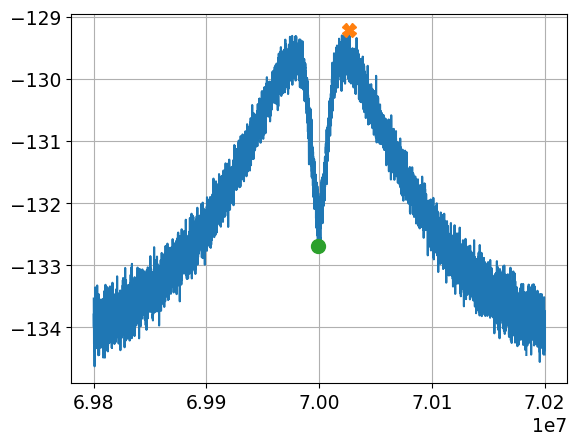

In [169]:
SNR_tank = find_SNR(freq, real_spectrum, debug=True)

### Single-stage amplifier
Electron -> Tank circuit -> Amplifier -> Spectrum Analyzer

In [170]:
n = 1  # number of electrons
d = 254e-6  # effective distance, in m
Q = 500  # quality factor of tank circuit
Z0 = 300  # characteristic impedance of the tank circuit, in Ohm
f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
delta_fz = fz_0 * 1e-4  # Width of the motional frequency of the electron
T = 4  # temperature of the tank circuit, in K

noise_preamp = 1e-9  # V/sqrt(Hz), noise level of the amplifier
G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
noise_hemt = 1e-9  # V/sqrt(Hz), noise level of the amplifier
G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier

BW_meas = 100  # Hz, measurement bandwidth
Z_meas = 50  # Ohm, measurement impedance
noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
plot_rg = 0.2e6  # Hz, plotting range
display_progress = False
N_average = 32  # The number of shots to take and do averaging on


pre_amp = Amplifier(G_preamp, noise_preamp)
devices = [pre_amp]

freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                            delta_fz, T,
                                            BW_meas, Z_meas, noise_floor,
                                            N_average, m, e, devices, 
                                            display_progress)

100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


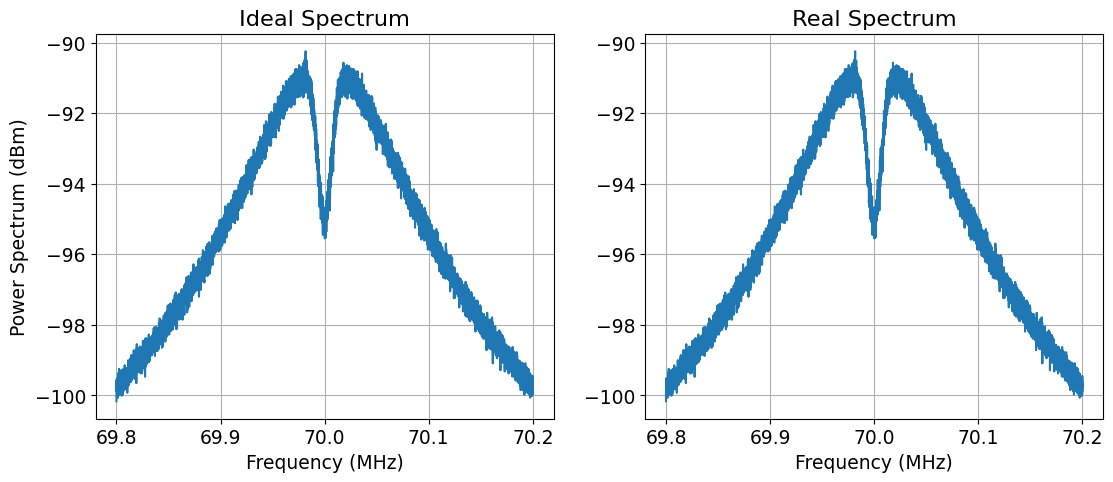

In [171]:
ideal_spectrum, real_spectrum = gaussian_electron(freq)
plot_power_spectrum(freq, ideal_spectrum, real_spectrum)

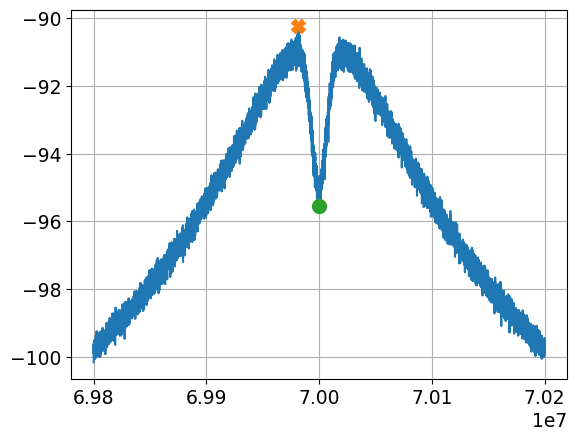

In [172]:
SNR_single_amp = find_SNR(freq, real_spectrum, debug=True)

### Two-stage amplifier
Electron -> Tank circuit -> Amplifier -> Bandpass filter -> Amplifier -> Spectrum Analyzer

In [173]:
n = 1  # number of electrons
d = 254e-6  # effective distance, in m
Q = 500  # quality factor of tank circuit
Z0 = 300  # characteristic impedance of the tank circuit, in Ohm
f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
delta_fz = fz_0 * 1e-4  # Width of the motional frequency of the electron
T = 4  # temperature of the tank circuit, in K

noise_preamp = 1e-9  # V/sqrt(Hz), noise level of the amplifier
G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
noise_hemt = 1e-9  # V/sqrt(Hz), noise level of the amplifier
G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier

BW_meas = 100  # Hz, measurement bandwidth
Z_meas = 50  # Ohm, measurement impedance
noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
plot_rg = 0.2e6  # Hz, plotting range
display_progress = False
N_average = 32  # The number of shots to take and do averaging on


pre_amp = Amplifier(G_preamp, noise_preamp)
bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
buffer_amp = Amplifier(G_hemt, noise_hemt)
devices = [pre_amp, bpf1, buffer_amp]

freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                            delta_fz, T,
                                            BW_meas, Z_meas, noise_floor,
                                            N_average, m, e, devices, 
                                            display_progress)

100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


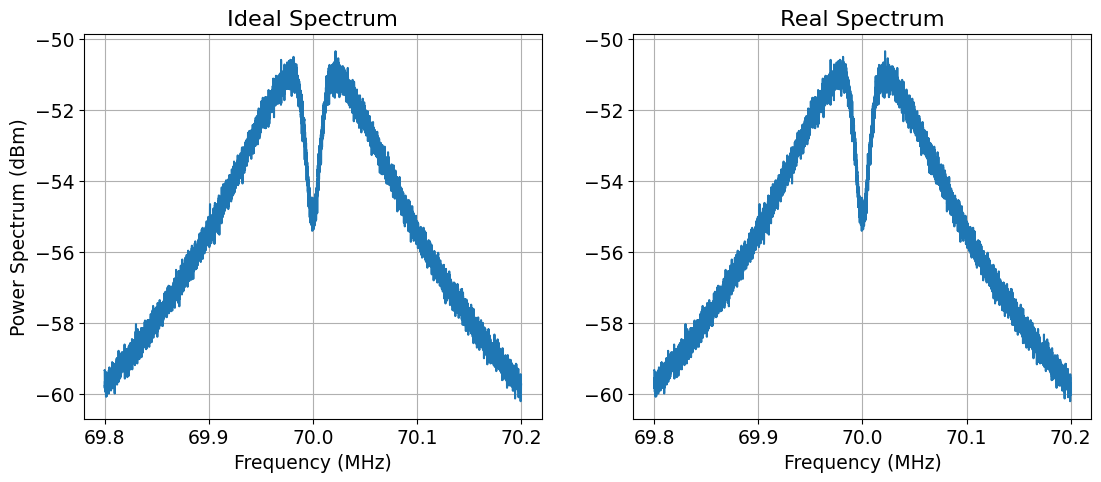

In [174]:
ideal_spectrum, real_spectrum = gaussian_electron(freq)
plot_power_spectrum(freq, ideal_spectrum, real_spectrum)

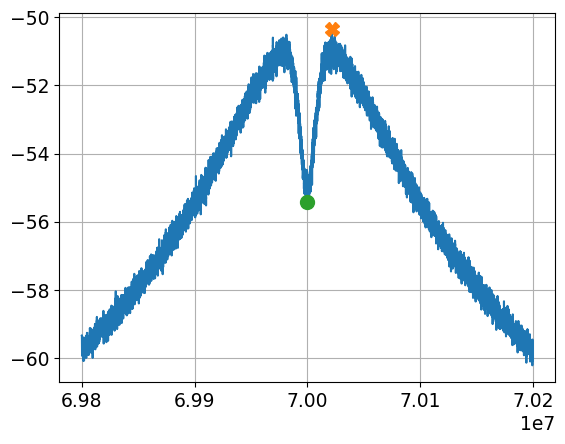

In [175]:
SNR_two_amp = find_SNR(freq, real_spectrum, debug=True)

### Compare effect

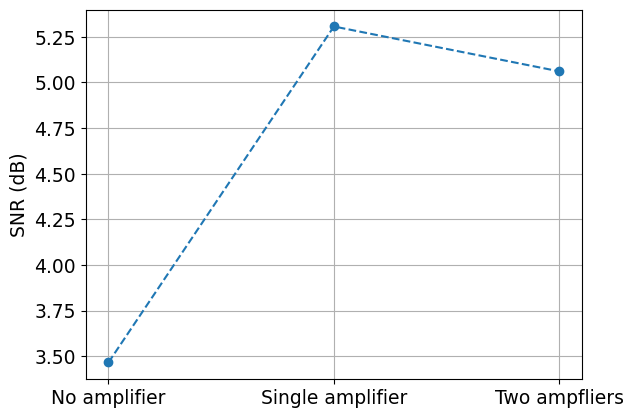

In [178]:
labels = ['No amplifier', 'Single amplifier', 'Two ampfliers']
SNRs = np.array([SNR_tank, SNR_single_amp, SNR_two_amp])
plot(labels, SNRs, 'o--', ylabel='SNR (dB)')

## Effective distance and anharmonicity

In [179]:
all_deff = np.logspace(-4, -2, 10)
all_width_factor = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

all_SNR_4_1 = []
for width_factor in all_width_factor:
    SNR, SNR_err = [], []
    for d in all_deff:
        n = 1  # number of electrons
        #d = 254e-6  # effective distance, in m
        Q = 500  # quality factor of tank circuit
        Z0 = 150e3/500  # characteristic impedance of the tank circuit, in Ohm
        f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
        fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
        delta_fz = fz_0 * width_factor  # Width of the motional frequency of the electron
        T = 4  # temperature of the tank circuit, in K
        
        noise_preamp = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        noise_hemt = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        
        BW_meas = 100  # Hz, measurement bandwidth
        Z_meas = 50  # Ohm, measurement impedance
        noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
        plot_rg = 0.2e6  # Hz, plotting range
        display_progress = False
        N_average = 32  # The number of shots to take and do averaging on
        
        
        pre_amp = Amplifier(G_preamp, noise_preamp)
        bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
        buffer_amp = Amplifier(G_hemt, noise_hemt)
        devices = [pre_amp, bpf1, buffer_amp]
        
        freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
        gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                                    delta_fz, T,
                                                    BW_meas, Z_meas, noise_floor,
                                                    N_average, m, e, devices, 
                                                    display_progress)
        ideal_spectrum, real_spectrum = gaussian_electron(freq)
        snr = find_SNR(freq, real_spectrum, debug=False)
        SNR.append(snr)
        
    all_SNR_4_1.append(SNR)

  0%|          | 0/32 [00:00<?, ?it/s]C:\Users\electron\edes\notebooks\detection_utils.py:63: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*W)
C:\Users\electron\edes\notebooks\detection_utils.py:63: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(1000*W)
100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


C:\Users\electron\AppData\Local\Temp\ipykernel_15220\2273240604.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f'{i:.3f}' for i in e**2*Q*Z0/m/(ax2.get_xticks()*1e-6)**2/2e3/np.pi])


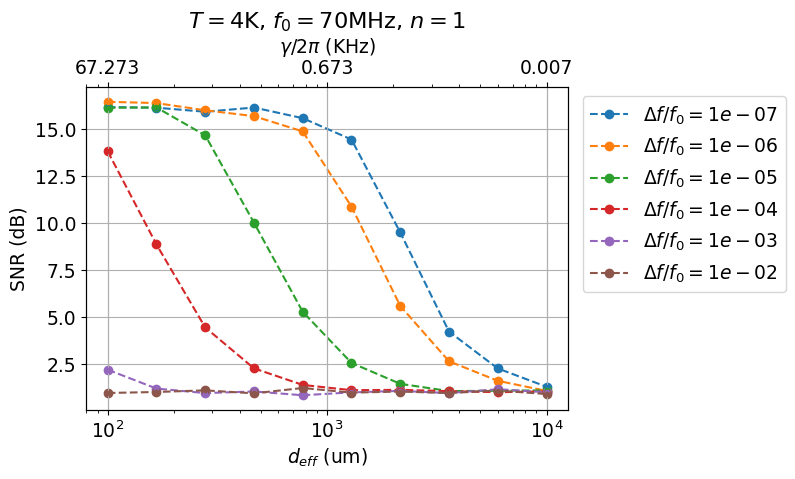

In [217]:
plot_SNR_variations(all_width_factor, all_deff, all_SNR_4_1, Q, Z0, T=4, n=1, f0=70)

## Temperature

In [181]:
all_deff = np.logspace(-4, -2, 10)
all_width_factor = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
#all_deff = np.linspace(100e-6, 1e-3, 2)
#all_width_factor = [1e-7, 1e-3]

all_SNR_300_1 = []
for width_factor in all_width_factor:
    SNR = []
    for d in all_deff:
        n = 1  # number of electrons
        #d = 254e-6  # effective distance, in m
        Q = 500  # quality factor of tank circuit
        Z0 = 150e3/500  # characteristic impedance of the tank circuit, in Ohm
        f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
        fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
        delta_fz = fz_0 * width_factor  # Width of the motional frequency of the electron
        T = 300  # temperature of the tank circuit, in K
        
        noise_preamp = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        noise_hemt = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        
        BW_meas = 100  # Hz, measurement bandwidth
        Z_meas = 50  # Ohm, measurement impedance
        noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
        plot_rg = 0.2e6  # Hz, plotting range
        display_progress = False
        N_average = 32  # The number of shots to take and do averaging on
        
        
        pre_amp = Amplifier(G_preamp, noise_preamp)
        bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
        buffer_amp = Amplifier(G_hemt, noise_hemt)
        devices = [pre_amp, bpf1, buffer_amp]
        
        freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
        gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                                    delta_fz, T,
                                                    BW_meas, Z_meas, noise_floor,
                                                    N_average, m, e, devices, 
                                                    display_progress)
        ideal_spectrum, real_spectrum = gaussian_electron(freq)
        snr = find_SNR(freq, real_spectrum, debug=False)
        SNR.append(snr)
    all_SNR_300_1.append(SNR)

100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


C:\Users\electron\AppData\Local\Temp\ipykernel_15220\2273240604.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f'{i:.3f}' for i in e**2*Q*Z0/m/(ax2.get_xticks()*1e-6)**2/2e3/np.pi])


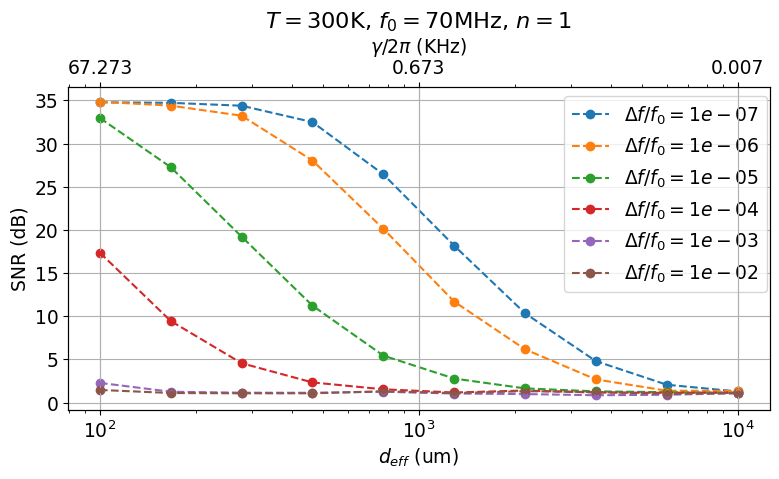

In [218]:
plot_SNR_variations(all_width_factor, all_deff, all_SNR_300_1, Q, Z0, T=300, n=1)

In [187]:
def thermal_distr_freq(dw, Tth):
    """
    Get the boltzmann distribution of frequency, following
        P(delta_omega) = exp{ T(delta_omega) / Tth },
    where T(delta_omega) is a fit done in anharmonicity 
    studies.
    
    Parameters
    ----------
    dw : [rad/s]
        Delta omega
    Tth : [K]
        Thermal temperature
    """
    dw = dw/1e6  # fitting is done in [2*pi * MHz]
    return np.exp(-(269.32*dw - 49.19*dw**2 + 19.1*dw**3)/Tth)

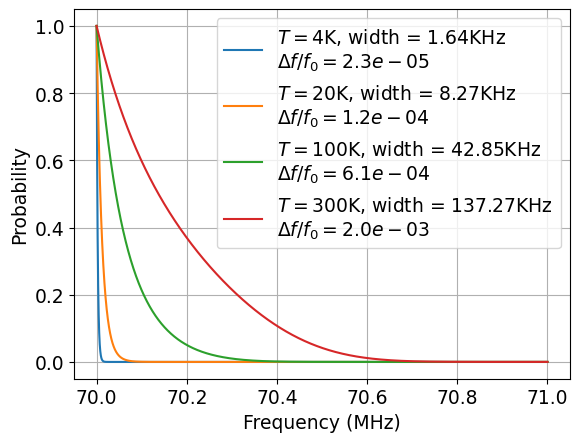

In [220]:
dw = 2e6*np.pi*np.linspace(0, 1, 1000000)
for Tth in [4, 20, 100, 300]:
    P_dw = thermal_distr_freq(dw, Tth)
    f_plot = (f0+dw/2/np.pi)/1e6  # in MHz
    width = dw[np.argmin(abs(P_dw-0.5))]/2/np.pi/1e3
    plot(f_plot, P_dw, label=f'$T = {Tth}$K, width = {width:.2f}KHz \n$\Delta f/f_0 = {width/f0*1e3:.1e}$')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Probability')
plt.legend()
plt.show()

## Number of Electrons

In [193]:
all_deff = np.logspace(-4, -2, 10)
all_width_factor = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
#all_deff = np.linspace(100e-6, 1e-3, 2)
#all_width_factor = [1e-7, 1e-3]

all_SNR_300_10 = []
for width_factor in all_width_factor:
    SNR = []
    for d in all_deff:
        n = 10  # number of electrons
        #d = 254e-6  # effective distance, in m
        Q = 500  # quality factor of tank circuit
        Z0 = 150e3/500  # characteristic impedance of the tank circuit, in Ohm
        f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
        fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
        delta_fz = fz_0 * width_factor  # Width of the motional frequency of the electron
        T = 300  # temperature of the tank circuit, in K
        
        noise_preamp = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        noise_hemt = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        
        BW_meas = 100  # Hz, measurement bandwidth
        Z_meas = 50  # Ohm, measurement impedance
        noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
        plot_rg = 0.2e6  # Hz, plotting range
        display_progress = False
        N_average = 32  # The number of shots to take and do averaging on
        
        
        pre_amp = Amplifier(G_preamp, noise_preamp)
        bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
        buffer_amp = Amplifier(G_hemt, noise_hemt)
        devices = [pre_amp, bpf1, buffer_amp]
        
        freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
        gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                                    delta_fz, T,
                                                    BW_meas, Z_meas, noise_floor,
                                                    N_average, m, e, devices, 
                                                    display_progress)
        ideal_spectrum, real_spectrum = gaussian_electron(freq)
        snr = find_SNR(freq, real_spectrum, debug=False)
        SNR.append(snr)
    all_SNR_300_10.append(SNR)

100%|██████████| 32/32 [00:03<00:00,  9.48it/s]


C:\Users\electron\AppData\Local\Temp\ipykernel_15220\2273240604.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f'{i:.3f}' for i in e**2*Q*Z0/m/(ax2.get_xticks()*1e-6)**2/2e3/np.pi])


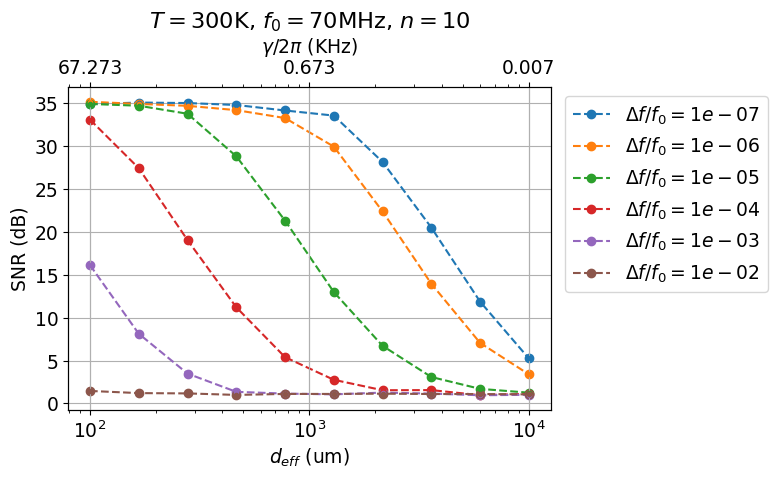

In [219]:
plot_SNR_variations(all_width_factor, all_deff, all_SNR_300_10, Q, Z0, T=300, n=10)

## Quick Approximations

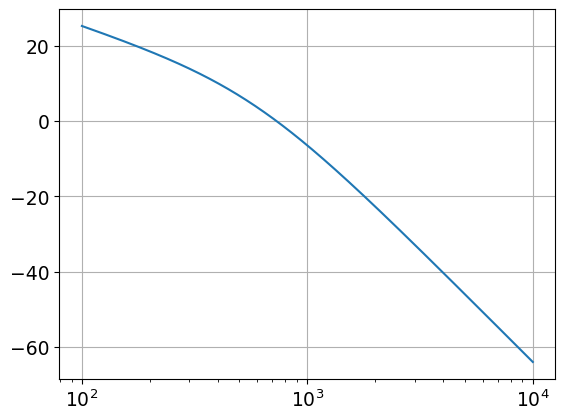

In [29]:
signal = lambda A, deff, Z, Qe, w0, n: (e*Z*A*w0/deff/(m*deff**2/e**2/Z*w0/Qe+1)*n)**2
noise = lambda Z, T, df: 4*kB*T*Z*df + dBm_to_W(-135)
T_to_amplitude = lambda T, w0: np.sqrt(kB/m/w0**2)

T = 300 
df = 100
n = 10
w0 = 2*np.pi * 200e6
A = T_to_amplitude(T, w0) 
deff = np.logspace(-4, -2, 1000)
Z = 150e3
Qe = 1e5 

plot(deff*1e6, frac_to_dB(signal(A, deff, Z, Qe, w0, n)/noise(Z, T, df)))
plt.xscale('log')

In [8]:
from tqdm import tqdm

In [11]:
all_deff = np.logspace(-4, -2, 10)
all_n = [1, 5, 10, 50, 100, 500, 1000]
all_BW = [100, 500, 1000]
#all_width_factor = [1e-7, 1e-3]

all_SNR_300_10 = []
for BW in all_BW:
    SNR = []
    for n in tqdm(all_n):
        #n = 10  # number of electrons
        d = 1e-3  # effective distance, in m
        Q = 500  # quality factor of tank circuit
        Z0 = 150e3/500  # characteristic impedance of the tank circuit, in Ohm
        f0 = 300e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
        fz_0 = 300e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
        delta_fz = fz_0 * 1e-3  # Width of the motional frequency of the electron
        T = 300  # temperature of the tank circuit, in K
        
        noise_preamp = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        noise_hemt = 1e-9  # V/sqrt(Hz), noise level of the amplifier
        G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
        
        BW_meas = BW  # Hz, measurement bandwidth
        Z_meas = 50  # Ohm, measurement impedance
        noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
        plot_rg = 0.2e6  # Hz, plotting range
        display_progress = 0
        N_average = 16  # The number of shots to take and do averaging on
        
        
        pre_amp = Amplifier(G_preamp, noise_preamp)
        bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
        buffer_amp = Amplifier(G_hemt, noise_hemt)
        devices = [pre_amp, bpf1, buffer_amp]
        
        freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
        gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                                    delta_fz, T,
                                                    BW_meas, Z_meas, noise_floor,
                                                    N_average, m, e, devices, 
                                                    display_progress)
        ideal_spectrum, real_spectrum = gaussian_electron(freq)
        snr = find_SNR(freq, real_spectrum, debug=False)
        SNR.append(snr)
    all_SNR_300_10.append(SNR)

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\electron\edes\edes\modules\detection\detection_utils.py:63: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*W)
C:\Users\electron\edes\edes\modules\detection\detection_utils.py:63: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(1000*W)
100%|██████████| 7/7 [01:40<00:00, 14.41s/it]


In [19]:
def plot_SNR_variations(all_width_factor, all_deff, all_SNR, Q, Z0, T, n, f0=70):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xscale('log')
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    for i in range(len(all_width_factor)):
        plot_ax(ax, all_deff, all_SNR[i], 'o--', label=f'$Bandwidth = {all_width_factor[i]:.0f}$')
        plot_ax(ax2, all_deff, all_SNR[i], '.')
    ax.set_ylabel('SNR (dB)')
    ax.set_xlabel('N electron')
    ax2.set_xlabel(r'$\tau$ (us)')
    ax2.set_xticklabels([f'{1e6/i:.2f}' for i in ax2.get_xticks()*e**2*Q*Z0/m/(1e-3)**2])
    ax.set_title(r'$T = $300K, $f_0 = $300MHz, $\Delta f/f_0 = 10^{-3}$')
    ax.legend(bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()

C:\Users\electron\AppData\Local\Temp\ipykernel_23040\2840689915.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f'{1e6/i:.2f}' for i in ax2.get_xticks()*e**2*Q*Z0/m/(1e-3)**2])


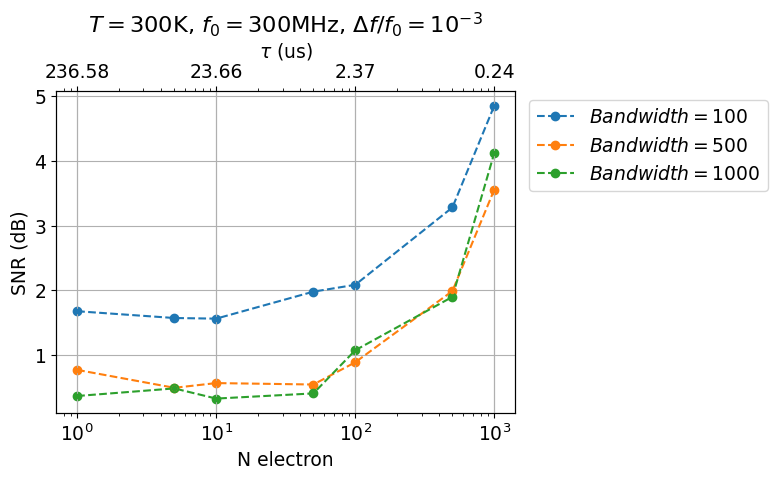

In [20]:
plot_SNR_variations(all_BW, all_n, all_SNR_300_10, Q, Z0, T=300, n=10)